To use C++ code in python, we have to build a class in C++ and then export it as a library that python can read. [This](https://www.auctoris.co.uk/2017/04/29/calling-c-classes-from-python-with-ctypes/) article makes that library.so and then uses ctypes when calling the class and passing it variables in python. [This](https://iq.opengenus.org/create-shared-library-in-cpp/) article has an alternate way of creating the library that is much simpler.

The way I structures this notebook to do soccer analysis is to write the file in a code cell here, then import it from the following code cell (stored in Drive). The class takes in 4 variables upon creation: home and away team atk and def ratings. Upon construction, the class calculates home and away win percentages, which can each be returned with a function call.

To test this, I can use values from the World Cup simulator, which will make the declarations in python trivial and avoid a significant amount of data manipulation.

In [ ]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %profile  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %shell  %store  %sx  %system  %tb  %tensorflow_version  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%bigquery  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%perl 

In [ ]:
%%writefile CalcWinPercentage.cpp

#include <iostream>
#include <cstring>
#include <cstdlib>
#include <string>
#include <cmath>

using namespace std;

class CalcWinPercentage {
    public:
        CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void calc(double homeAtk, double homeDef, double awayAtk, double awayDef);
        void reset() {
            homewin = 0.0;
            awaywin = 0.0;
        }
        double homewinpercentage() {return homewin;}
        double awaywinpercentage() {return awaywin;}
        int factorial (int num);
        
        const float avgGoals = 1.56;
 
    private:
        double homewin, awaywin;
};

CalcWinPercentage::CalcWinPercentage(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    homewin = 0;
    awaywin = 0;

    int i, j;
    float scoreChance, homeExpGoals, awayExpGoals;
 
    // this is broken because the formula is based on percentages, so 1 - x is positive
    homeExpGoals = ((homeAtk * awayDef) / avgGoals) / ((homeAtk * awayDef) / avgGoals + (avgGoals/ (homeAtk * awayDef)));
    awayExpGoals = ((awayAtk * homeDef) / avgGoals) / ((awayAtk * homeDef) / avgGoals + ((1 - awayAtk) * (1 - homeDef) / (1 - avgGoals)));
 
    for (i = 0; i < 8; i++) {
        for (j = 0; j < 8; j++) {
            scoreChance = pow(homeExpGoals, i) * pow(awayExpGoals, j) * exp(-(homeExpGoals + awayExpGoals)) / (factorial(i) * factorial(j));
            if (i > j) {
                homewin += scoreChance;
            }
            if (j > i) {
                awaywin += scoreChance;
            }
        }
    }

    homewin = homeExpGoals;
    awaywin = awayExpGoals;
}

void CalcWinPercentage::calc(double homeAtk, double homeDef, double awayAtk, double awayDef) {
    int i, j;
    float scoreChance;
    homewin = 0;
    awaywin = 4.5;
 
}

int CalcWinPercentage::factorial (int num) {
    int result = 1;
    if (num > 0) {
        for (int i = num; i > 1; i--) {
            result *= i;
        }
    }
    return result;
}

// Define C functions for the C++ class that can be accessed by ctypes

extern "C"
{
    CalcWinPercentage* CWP_new(double ha, double hd, double aa, double ad) {return new CalcWinPercentage(ha, hd, aa, ad);}
    void CWP_calc(CalcWinPercentage* cwp, double ha, double hd, double aa, double ad) {cwp->calc(ha, hd, aa, ad);}
    void CWP_reset(CalcWinPercentage* cwp) {cwp->reset();}
    double CWP_homewinpercentage(CalcWinPercentage* cwp) {return cwp->homewinpercentage();}
    double CWP_awaywinpercentage(CalcWinPercentage* cwp) {return cwp->awaywinpercentage();}
    int CWP_factorial(CalcWinPercentage* cwp, int num) {return cwp->factorial(num);}
}

Writing CalcWinPercentage.cpp


In [ ]:
!rm libCalcWinPercentage.so
!rm CalcWinPercentage.o
!ls -l

rm: cannot remove 'libCalcWinPercentage.so': No such file or directory
rm: cannot remove 'CalcWinPercentage.o': No such file or directory
total 12
-rw-r--r-- 1 root root 2649 Jul 10 03:14 CalcWinPercentage.cpp
drwx------ 5 root root 4096 Jul 10 03:08 drive
drwxr-xr-x 1 root root 4096 Jul  6 13:22 sample_data


In [ ]:
!g++ -c -fPIC CalcWinPercentage.cpp -o CalcWinPercentage.o
!gcc -shared -o libCalcWinPercentage.so CalcWinPercentage.o
!ls -l

total 36
-rw-r--r-- 1 root root  2660 Jul 20 01:18 CalcWinPercentage.cpp
-rw-r--r-- 1 root root  7952 Jul 20 01:19 CalcWinPercentage.o
drwx------ 5 root root  4096 Jul 20 01:18 drive
-rwxr-xr-x 1 root root 13608 Jul 20 01:19 libCalcWinPercentage.so
drwxr-xr-x 1 root root  4096 Jul 13 13:43 sample_data


In [ ]:
import ctypes
import numpy as np
import pandas as pd

lib = ctypes.cdll.LoadLibrary('/content/libCalcWinPercentage.so')

class CalcWinPercentage:
  def __init__(self, ha, hd, aa, ad):
    lib.CWP_new.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_new.restype = ctypes.c_void_p

    lib.CWP_calc.argtypes = [ctypes.c_void_p, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
    lib.CWP_calc.restype = ctypes.c_void_p

    lib.CWP_reset.argtypes = [ctypes.c_void_p]
    lib.CWP_reset.restype = ctypes.c_void_p

    lib.CWP_homewinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_homewinpercentage.restype = ctypes.c_double

    lib.CWP_awaywinpercentage.argtypes = [ctypes.c_void_p]
    lib.CWP_awaywinpercentage.restype = ctypes.c_double

    lib.CWP_factorial.argtypes = [ctypes.c_void_p, ctypes.c_int]
    lib.CWP_factorial.restype = ctypes.c_int

    self.obj = lib.CWP_new(ha, hd, aa, ad)

  def calc(self, ha, hd, aa, ad):
    lib.CWP_calc(self.obj, ha, hd, aa, ad)

  def reset(self):
    lib.CWP_reset(self.obj)

  def homewinpercentage(self):
    return lib.CWP_homewinpercentage(self.obj)

  def awaywinpercentage(self):
    return lib.CWP_awaywinpercentage(self.obj)

# from lib import CalcWinPercentage

# Test that the C++ library is working

cwp = CalcWinPercentage(4, 5, 6.7, 7)
print(cwp.awaywinpercentage())
print(cwp.homewinpercentage())
cwp.reset()
print(cwp.awaywinpercentage())

In [1]:
# EPL

from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns


# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

EPL_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/EPL/2021-2022.csv')
EPL_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/EPL/2020-2021.csv')
EPL_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/EPL/2019-2020.csv')
EPL_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/EPL/2018-2019.csv')
EPL_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/EPL/2017-2018.csv')
EPL_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/EPL/2016-2017.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
EPL_match_odds = EPL_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
EPL_match_odds = EPL_match_odds.append(EPL_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
EPL_match_odds['B365A'] = EPL_match_odds['B365A'].apply(lambda x: 1/x)
EPL_match_odds['B365D'] = EPL_match_odds['B365D'].apply(lambda x: 1/x)
EPL_match_odds['B365H'] = EPL_match_odds['B365H'].apply(lambda x: 1/x)

# This changes any necessary team names so they are sorted exactly the same in both dataframes
spi_matches_league = spi_matches[spi_matches['league'] == 'Barclays Premier League']
spi_matches_league = spi_matches_league.replace(to_replace='AFC Bournemouth', value='Bournemouth').sort_values(['season', 'team1', 'team2'])

# Arrays to build the game_data DataFrame
season = [np.array(spi_matches_league['season'])[x+10] for x in range(len(spi_matches_league) -10)]
date = [np.array(spi_matches_league['date'])[x+10] for x in range(len(spi_matches_league) - 10)]
hometeam = [np.array(spi_matches_league['team1'])[x+10] for x in range(len(spi_matches_league) - 10)]
home_goals = [np.array(spi_matches_league['xg1'])[x+10] for x in range(len(spi_matches_league) - 10)]
away_goals = [np.array(spi_matches_league['xg2'])[x+10] for x in range(len(spi_matches_league) - 10)]
awayteam = [np.array(spi_matches_league['team2'])[x+10] for x in range(len(spi_matches_league) - 10)]
result = [np.array(EPL_match_odds['FTR'])[x+10] for x in range(len(EPL_match_odds) - 10)]
home_odds = [np.array(EPL_match_odds['B365H'])[x+10] for x in range(len(EPL_match_odds) - 10)]
away_odds = [np.array(EPL_match_odds['B365A'])[x+10] for x in range(len(EPL_match_odds) - 10)]
draw_odds = [np.array(EPL_match_odds['B365D'])[x+10] for x in range(len(EPL_match_odds) - 10)]
pythag = np.divide(np.multiply(home_goals, home_goals), np.add(np.multiply(home_goals, home_goals), np.multiply(away_goals, away_goals)))

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_league is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

lg_avg_home = spi_matches_league['xg1'].sum()/len(spi_matches_league)
lg_avg_away = spi_matches_league['xg2'].sum()/len(spi_matches_league)

game_data = pd.DataFrame({'Season': np.array(season),
                          'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals),
                          'Goal Difference': np.array(home_goals) - np.array(away_goals),
                          'Pythag': np.array(pythag),
                          'Result': np.array(result),
                          'Home Odds': np.array(home_odds),
                          'Away Odds': np.array(away_odds),
                          'Draw Odds': np.array(draw_odds)})

# This slice creates a sample that can be used to generate better atk/def ratings
# Keep in mind that this extra data used to create ratings does not apply to promoted teams
game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_league) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
game_data = game_data.dropna()
game_data = game_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

print(spi_matches['season'].unique())

[2016 2017 2018 2019 2020 2021 2022]


In [ ]:
# Eredivisie

from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns


# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

Eredivisie_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Eredivisie/2021-2022.csv')
Eredivisie_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Eredivisie/2020-2021.csv')
Eredivisie_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Eredivisie/2019-2020.csv')
Eredivisie_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Eredivisie/2018-2019.csv')
Eredivisie_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Eredivisie/2017-2018.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
Eredivisie_match_odds = Eredivisie_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
Eredivisie_match_odds = Eredivisie_match_odds.append(Eredivisie_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Eredivisie_match_odds = Eredivisie_match_odds.append(Eredivisie_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Eredivisie_match_odds = Eredivisie_match_odds.append(Eredivisie_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Eredivisie_match_odds = Eredivisie_match_odds.append(Eredivisie_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
Eredivisie_match_odds['B365A'] = Eredivisie_match_odds['B365A'].apply(lambda x: 1/x)
Eredivisie_match_odds['B365D'] = Eredivisie_match_odds['B365D'].apply(lambda x: 1/x)
Eredivisie_match_odds['B365H'] = Eredivisie_match_odds['B365H'].apply(lambda x: 1/x)

# This changes any necessary team names so they are sorted exactly the same in both dataframes
spi_matches_league = spi_matches[spi_matches['league'] == 'Dutch Eredivisie'].reset_index(drop=True)
spi_matches_league = spi_matches_league[spi_matches_league['score1'].notna()]
spi_matches_league = spi_matches_league.replace(to_replace='FC Groningen', value='Groningen')
spi_matches_league = spi_matches_league.replace(to_replace='FC Twente', value='Twente')
spi_matches_league = spi_matches_league.replace(to_replace='FC Utrecht', value='Utrecht')
spi_matches_league = spi_matches_league.replace(to_replace='De Graafschap', value='Graafschap')
spi_matches_league = spi_matches_league.replace(to_replace='PEC Zwolle', value='Zwolle')
spi_matches_league = spi_matches_league.replace(to_replace='Emmen', value='FC Emmen')
spi_matches_league = spi_matches_league.replace(to_replace='RKC', value='Waalwijk')
spi_matches_league = spi_matches_league.replace(to_replace='NEC', value='Nijmegen')
spi_matches_league = spi_matches_league.replace(to_replace='ADO Den Haag', value='Den Haag').sort_values(['season', 'team1', 'team2'])

# Arrays to build the game_data DataFrame
season = [np.array(spi_matches_league['season'])[x+10] for x in range(len(spi_matches_league) -10)]
date = [np.array(spi_matches_league['date'])[x+10] for x in range(len(spi_matches_league) - 10)]
hometeam = [np.array(spi_matches_league['team1'])[x+10] for x in range(len(spi_matches_league) - 10)]
home_goals = [np.array(spi_matches_league['xg1'])[x+10] for x in range(len(spi_matches_league) - 10)]
away_goals = [np.array(spi_matches_league['xg2'])[x+10] for x in range(len(spi_matches_league) - 10)]
awayteam = [np.array(spi_matches_league['team2'])[x+10] for x in range(len(spi_matches_league) - 10)]
result = [np.array(Eredivisie_match_odds['FTR'])[x+10] for x in range(len(Eredivisie_match_odds) - 10)]
home_odds = [np.array(Eredivisie_match_odds['B365H'])[x+10] for x in range(len(Eredivisie_match_odds) - 10)]
away_odds = [np.array(Eredivisie_match_odds['B365A'])[x+10] for x in range(len(Eredivisie_match_odds) - 10)]
draw_odds = [np.array(Eredivisie_match_odds['B365D'])[x+10] for x in range(len(Eredivisie_match_odds) - 10)]
pythag = np.divide(np.multiply(home_goals, home_goals), np.add(np.multiply(home_goals, home_goals), np.multiply(away_goals, away_goals)))

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_league is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

lg_avg_home = spi_matches_league['xg1'].sum()/len(spi_matches_league)
lg_avg_away = spi_matches_league['xg2'].sum()/len(spi_matches_league)

game_data = pd.DataFrame({'Season': np.array(season),
                          'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals),
                          'Goal Difference': np.array(home_goals) - np.array(away_goals),
                          'Pythag': np.array(pythag),
                          'Result': np.array(result),
                          'Home Odds': np.array(home_odds),
                          'Away Odds': np.array(away_odds),
                          'Draw Odds': np.array(draw_odds)})

# This slice creates a sample that can be used to generate better atk/def ratings
# Keep in mind that this extra data used to create ratings does not apply to promoted teams
game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_league) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
game_data = game_data.dropna()
game_data = game_data.reset_index(drop=True).replace(to_replace=0, value=0.01)


In [ ]:
# Bundesliga

from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns


# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

Bundesliga_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Bundesliga/2021-2022.csv')
Bundesliga_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Bundesliga/2020-2021.csv')
Bundesliga_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Bundesliga/2019-2020.csv')
Bundesliga_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Bundesliga/2018-2019.csv')
Bundesliga_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Bundesliga/2017-2018.csv')
Bundesliga_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/Bundesliga/2016-2017.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
Bundesliga_match_odds = Bundesliga_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
Bundesliga_match_odds = Bundesliga_match_odds.append(Bundesliga_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Bundesliga_match_odds = Bundesliga_match_odds.append(Bundesliga_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Bundesliga_match_odds = Bundesliga_match_odds.append(Bundesliga_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Bundesliga_match_odds = Bundesliga_match_odds.append(Bundesliga_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
Bundesliga_match_odds = Bundesliga_match_odds.append(Bundesliga_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
Bundesliga_match_odds['B365A'] = Bundesliga_match_odds['B365A'].apply(lambda x: 1/x)
Bundesliga_match_odds['B365D'] = Bundesliga_match_odds['B365D'].apply(lambda x: 1/x)
Bundesliga_match_odds['B365H'] = Bundesliga_match_odds['B365H'].apply(lambda x: 1/x)

# This changes any necessary team names so they are sorted exactly the same in both dataframes
spi_matches_league = spi_matches[spi_matches['league'] == 'German Bundesliga']
spi_matches_league = spi_matches_league.replace(to_replace='FC Augsburg', value='Augsburg')
spi_matches_league = spi_matches_league.replace(to_replace='Borussia Dortmund', value='Dortmund')
spi_matches_league = spi_matches_league.replace(to_replace='Borussia Monchengladbach', value="M'gladbach")
spi_matches_league = spi_matches_league.replace(to_replace='Bayer Leverkusen', value='Leverkusen')
spi_matches_league = spi_matches_league.replace(to_replace='SpVgg Greuther Fürth', value='Greuther Fürth')
spi_matches_league = spi_matches_league.replace(to_replace='SV Darmstadt 98', value='Darmstadt')
spi_matches_league = spi_matches_league.replace(to_replace='FC Ingolstadt 04', value='Ingolstadt')
spi_matches_league = spi_matches_league.replace(to_replace='SC Freiburg', value='Freiburg')
spi_matches_league = spi_matches_league.replace(to_replace='Arminia Bielefeld', value='Bielefeld')
spi_matches_league = spi_matches_league.replace(to_replace='SC Paderborn', value='Paderborn')
spi_matches_league = spi_matches_league.replace(to_replace='1. FC Union Berlin', value='Union Berlin')
spi_matches_league = spi_matches_league.replace(to_replace='VfL Bochum', value='Bochum')
spi_matches_league = spi_matches_league.replace(to_replace='1. FC Nürnberg', value='Nürnberg')
spi_matches_league = spi_matches_league.replace(to_replace='FC Cologne', value='FC Koln')
spi_matches_league = spi_matches_league.replace(to_replace='Fortuna Düsseldorf', value='Fortuna Dusseldorf')
spi_matches_league = spi_matches_league.replace(to_replace='VfB Stuttgart', value='Stuttgart')
spi_matches_league = spi_matches_league.replace(to_replace='VfL Wolfsburg', value='Wolfsburg')
spi_matches_league = spi_matches_league.replace(to_replace='VfL Bochum', value='Bochum')
spi_matches_league = spi_matches_league.replace(to_replace='TSG Hoffenheim', value='Hoffenheim').sort_values(['season', 'team1', 'team2'])

# Arrays to build the game_data DataFrame
season = [np.array(spi_matches_league['season'])[x+10] for x in range(len(spi_matches_league) -10)]
date = [np.array(spi_matches_league['date'])[x+10] for x in range(len(spi_matches_league) - 10)]
hometeam = [np.array(spi_matches_league['team1'])[x+10] for x in range(len(spi_matches_league) - 10)]
home_goals = [np.array(spi_matches_league['xg1'])[x+10] for x in range(len(spi_matches_league) - 10)]
away_goals = [np.array(spi_matches_league['xg2'])[x+10] for x in range(len(spi_matches_league) - 10)]
awayteam = [np.array(spi_matches_league['team2'])[x+10] for x in range(len(spi_matches_league) - 10)]
result = [np.array(Bundesliga_match_odds['FTR'])[x+10] for x in range(len(Bundesliga_match_odds) - 10)]
home_odds = [np.array(Bundesliga_match_odds['B365H'])[x+10] for x in range(len(Bundesliga_match_odds) - 10)]
away_odds = [np.array(Bundesliga_match_odds['B365A'])[x+10] for x in range(len(Bundesliga_match_odds) - 10)]
draw_odds = [np.array(Bundesliga_match_odds['B365D'])[x+10] for x in range(len(Bundesliga_match_odds) - 10)]
pythag = np.divide(np.multiply(home_goals, home_goals), np.add(np.multiply(home_goals, home_goals), np.multiply(away_goals, away_goals)))

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_league is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

lg_avg_home = spi_matches_league['xg1'].sum()/len(spi_matches_league)
lg_avg_away = spi_matches_league['xg2'].sum()/len(spi_matches_league)

game_data = pd.DataFrame({'Season': np.array(season),
                          'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals),
                          'Goal Difference': np.array(home_goals) - np.array(away_goals),
                          'Pythag': np.array(pythag),
                          'Result': np.array(result),
                          'Home Odds': np.array(home_odds),
                          'Away Odds': np.array(away_odds),
                          'Draw Odds': np.array(draw_odds)})

# This slice creates a sample that can be used to generate better atk/def ratings
# Keep in mind that this extra data used to create ratings does not apply to promoted teams
game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_league) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
game_data = game_data.dropna()
game_data = game_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

print(Bundesliga_match_odds['HomeTeam'].unique())
print(spi_matches_league['team1'].unique())

['Augsburg' 'Bayern Munich' 'Darmstadt' 'Dortmund' 'Ein Frankfurt'
 'FC Koln' 'Freiburg' 'Hamburg' 'Hertha' 'Hoffenheim' 'Ingolstadt'
 'Leverkusen' "M'gladbach" 'Mainz' 'RB Leipzig' 'Schalke 04'
 'Werder Bremen' 'Wolfsburg' 'Hannover' 'Stuttgart' 'Fortuna Dusseldorf'
 'Nurnberg' 'Paderborn' 'Union Berlin' 'Bielefeld' 'Bochum'
 'Greuther Furth']
['Augsburg' 'Bayern Munich' 'Darmstadt' 'Dortmund' 'Eintracht Frankfurt'
 'FC Koln' 'Freiburg' 'Hamburg SV' 'Hertha Berlin' 'Hoffenheim'
 'Ingolstadt' 'Leverkusen' "M'gladbach" 'Mainz' 'RB Leipzig' 'Schalke 04'
 'Werder Bremen' 'Wolfsburg' 'Hannover 96' 'Stuttgart'
 'Fortuna Dusseldorf' 'Nürnberg' 'Paderborn' 'Union Berlin' 'Bielefeld'
 'Bochum' 'Greuther Fürth']


In [ ]:
# La Liga

from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns


# Code block will analyze EPL data
# Load the data into variables
spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

La_Liga_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2021-2022.csv')
La_Liga_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2020-2021.csv')
La_Liga_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2019-2020.csv')
La_Liga_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2018-2019.csv')
La_Liga_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2017-2018.csv')
La_Liga_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2016-2017.csv')

# This section stores the data I want to use regarding betting markets in a new dataframe
keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
La_Liga_match_odds = La_Liga_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
La_Liga_match_odds = La_Liga_match_odds.replace(to_replace='Espanol', value='Espanyol')

# This section converts the data into usable forms
# Converting between decimal odds and implied probability is just y = 1/x
La_Liga_match_odds['B365A'] = La_Liga_match_odds['B365A'].apply(lambda x: 1/x)
La_Liga_match_odds['B365D'] = La_Liga_match_odds['B365D'].apply(lambda x: 1/x)
La_Liga_match_odds['B365H'] = La_Liga_match_odds['B365H'].apply(lambda x: 1/x)

# This changes the team names so they are the same in both dataframes
# This ensures they are sorted exactly the same
spi_matches_league = spi_matches[spi_matches['league'] == 'Spanish Primera Division']
spi_matches_league = spi_matches_league.replace(to_replace='Athletic Bilbao', value='Ath Bilbao')
spi_matches_league = spi_matches_league.replace(to_replace='Atletico Madrid', value='Ath Madrid')
spi_matches_league = spi_matches_league.replace(to_replace='Deportivo La Coruña', value='La Coruna')
spi_matches_league = spi_matches_league.replace(to_replace='Real Betis', value='Betis')
spi_matches_league = spi_matches_league.replace(to_replace='Girona FC', value='Girona')
spi_matches_league = spi_matches_league.replace(to_replace='Sevilla FC', value='Sevilla')
spi_matches_league = spi_matches_league.replace(to_replace='Rayo Vallecano', value='Vallecano')
spi_matches_league = spi_matches_league.replace(to_replace='Real Valladolid', value='Valladolid')
spi_matches_league = spi_matches_league.replace(to_replace='SD Huesca', value='Huesca')
spi_matches_league = spi_matches_league.replace(to_replace='Sporting Gijón', value='Sp Gijon')
spi_matches_league = spi_matches_league.replace(to_replace='Real Sociedad', value='Sociedad')
spi_matches_league = spi_matches_league.replace(to_replace='Celta Vigo', value='Celta').sort_values(['season', 'team1', 'team2'])

# Arrays to build the game_data DataFrame
season = [np.array(spi_matches_league['season'])[x+10] for x in range(len(spi_matches_league) -10)]
date = [np.array(spi_matches_league['date'])[x+10] for x in range(len(spi_matches_league) - 10)]
hometeam = [np.array(spi_matches_league['team1'])[x+10] for x in range(len(spi_matches_league) - 10)]
home_goals = [np.array(spi_matches_league['xg1'])[x+10] for x in range(len(spi_matches_league) - 10)]
away_goals = [np.array(spi_matches_league['xg2'])[x+10] for x in range(len(spi_matches_league) - 10)]
awayteam = [np.array(spi_matches_league['team2'])[x+10] for x in range(len(spi_matches_league) - 10)]
result = [np.array(La_Liga_match_odds['FTR'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
home_odds = [np.array(La_Liga_match_odds['B365H'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
away_odds = [np.array(La_Liga_match_odds['B365A'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
draw_odds = [np.array(La_Liga_match_odds['B365D'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
pythag = np.divide(np.multiply(home_goals, home_goals), np.add(np.multiply(home_goals, home_goals), np.multiply(away_goals, away_goals)))

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_league is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

lg_avg_home = spi_matches_league['xg1'].sum()/len(spi_matches_league)
lg_avg_away = spi_matches_league['xg2'].sum()/len(spi_matches_league)

game_data = pd.DataFrame({'Season': np.array(season),
                          'Date': np.array(date),
                          'Home Team': np.array(hometeam),
                          'Away Team': np.array(awayteam),
                          'Home Goals': np.array(home_goals),
                          'Away Goals': np.array(away_goals),
                          'Goal Difference': np.array(home_goals) - np.array(away_goals),
                          'Pythag': np.array(pythag),
                          'Result': np.array(result),
                          'Home Odds': np.array(home_odds),
                          'Away Odds': np.array(away_odds),
                          'Draw Odds': np.array(draw_odds)})

# This slice creates a sample that can be used to generate better atk/def ratings
# Keep in mind that this extra data used to create ratings does not apply to promoted teams
game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_league) for x in range(len(game_data))]
game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
game_data = game_data.dropna()
game_data = game_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

In [1]:
import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime

global game_data, spi_matches_league

# Object to handle data manipulation; initialized to create ratings
# Assumes spi_matches_league is the df being passed
class CalcTeamRatings:
  def __init__(self, home, away, date, df):
    self.home = home
    self.date = date
    self.away = away
    self.df = df[df['date'] < self.date].sort_values(['date'])
    self.df = self.df.dropna()
    self.home_df = self.df[self.df['team1'] == self.home]
    self.home_df = self.home_df.tail(30)
    self.away_df = self.df[self.df['team2'] == self.away]
    self.away_df = self.away_df.tail(30)
  def rollingAvgXG(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg1'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg1'].tail(10).mean() + self.home_df['xg1'].mean()) / 2)
    old_games = self.home_df['xg1'].head(20).mean()
    new_games = self.home_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def rollingAvgXGA(self):
    if (len(self.home_df) < 10):
      return self.home_df['xg2'].mean()
    if (len(self.home_df) < 20):
      return ((self.home_df['xg2'].tail(10).mean() + self.home_df['xg2'].mean()) / 2)
    old_games = self.home_df['xg2'].head(20).mean()
    new_games = self.home_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXG(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg2'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg2'].tail(10).mean() + self.away_df['xg2'].mean()) / 2)
    old_games = self.away_df['xg2'].head(20).mean()
    new_games = self.away_df['xg2'].tail(10).mean()
    return ((old_games + new_games) / 2)
  def away_rollingAvgXGA(self):
    if (len(self.away_df) < 10):
      return self.away_df['xg1'].mean()
    if (len(self.away_df) < 20):
      return ((self.away_df['xg1'].tail(10).mean() + self.away_df['xg1'].mean()) / 2)
    old_games = self.away_df['xg1'].head(20).mean()
    new_games = self.away_df['xg1'].tail(10).mean()
    return ((old_games + new_games) / 2)

def LaLiga(temp):
  global game_data, spi_matches_league
  output.clear_output()
  now = datetime.now()
  with output:
    print('Start running La Liga at: ', now)

  # Code block will analyze EPL data
  # Load the data into variables
  spi_global_ranking = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_global_rankings.csv')
  spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
  spi_matches_latest = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches_latest.csv')

  La_Liga_match_odds_2122 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2021-2022.csv')
  La_Liga_match_odds_2021 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2020-2021.csv')
  La_Liga_match_odds_1920 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2019-2020.csv')
  La_Liga_match_odds_1819 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2018-2019.csv')
  La_Liga_match_odds_1718 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2017-2018.csv')
  La_Liga_match_odds_1617 = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/Betting Odds/La Liga/2016-2017.csv')

  # This section stores the data I want to use regarding betting markets in a new dataframe
  keep_cols = ['HomeTeam', 'AwayTeam', 'B365H', 'B365A', 'B365D', 'FTR', 'HTR']
  La_Liga_match_odds = La_Liga_match_odds_1617[keep_cols].sort_values(['HomeTeam', 'AwayTeam'])
  La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_1718[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
  La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_1819[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
  La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_1920[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
  La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_2021[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
  La_Liga_match_odds = La_Liga_match_odds.append(La_Liga_match_odds_2122[keep_cols].sort_values(['HomeTeam', 'AwayTeam']))
  La_Liga_match_odds = La_Liga_match_odds.replace(to_replace='Espanol', value='Espanyol')

  # This section converts the data into usable forms
  # Converting between decimal odds and implied probability is just y = 1/x
  La_Liga_match_odds['B365A'] = La_Liga_match_odds['B365A'].apply(lambda x: 1/x)
  La_Liga_match_odds['B365D'] = La_Liga_match_odds['B365D'].apply(lambda x: 1/x)
  La_Liga_match_odds['B365H'] = La_Liga_match_odds['B365H'].apply(lambda x: 1/x)

  # This changes the team names so they are the same in both dataframes
  # This ensures they are sorted exactly the same
  spi_matches_league = spi_matches[spi_matches['league'] == 'Spanish Primera Division']
  spi_matches_league = spi_matches_league.replace(to_replace='Athletic Bilbao', value='Ath Bilbao')
  spi_matches_league = spi_matches_league.replace(to_replace='Atletico Madrid', value='Ath Madrid')
  spi_matches_league = spi_matches_league.replace(to_replace='Deportivo La Coruña', value='La Coruna')
  spi_matches_league = spi_matches_league.replace(to_replace='Real Betis', value='Betis')
  spi_matches_league = spi_matches_league.replace(to_replace='Girona FC', value='Girona')
  spi_matches_league = spi_matches_league.replace(to_replace='Sevilla FC', value='Sevilla')
  spi_matches_league = spi_matches_league.replace(to_replace='Rayo Vallecano', value='Vallecano')
  spi_matches_league = spi_matches_league.replace(to_replace='Real Valladolid', value='Valladolid')
  spi_matches_league = spi_matches_league.replace(to_replace='SD Huesca', value='Huesca')
  spi_matches_league = spi_matches_league.replace(to_replace='Sporting Gijón', value='Sp Gijon')
  spi_matches_league = spi_matches_league.replace(to_replace='Real Sociedad', value='Sociedad')
  spi_matches_league = spi_matches_league.replace(to_replace='Celta Vigo', value='Celta').sort_values(['season', 'team1', 'team2'])

  # Arrays to build the game_data DataFrame
  season = [np.array(spi_matches_league['season'])[x+10] for x in range(len(spi_matches_league) -10)]
  date = [np.array(spi_matches_league['date'])[x+10] for x in range(len(spi_matches_league) - 10)]
  hometeam = [np.array(spi_matches_league['team1'])[x+10] for x in range(len(spi_matches_league) - 10)]
  home_goals = [np.array(spi_matches_league['xg1'])[x+10] for x in range(len(spi_matches_league) - 10)]
  away_goals = [np.array(spi_matches_league['xg2'])[x+10] for x in range(len(spi_matches_league) - 10)]
  awayteam = [np.array(spi_matches_league['team2'])[x+10] for x in range(len(spi_matches_league) - 10)]
  result = [np.array(La_Liga_match_odds['FTR'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
  home_odds = [np.array(La_Liga_match_odds['B365H'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
  away_odds = [np.array(La_Liga_match_odds['B365A'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
  draw_odds = [np.array(La_Liga_match_odds['B365D'])[x+10] for x in range(len(La_Liga_match_odds) - 10)]
  pythag = np.divide(np.multiply(home_goals, home_goals), np.add(np.multiply(home_goals, home_goals), np.multiply(away_goals, away_goals)))

  lg_avg_home = spi_matches_league['xg1'].sum()/len(spi_matches_league)
  lg_avg_away = spi_matches_league['xg2'].sum()/len(spi_matches_league)

  game_data = pd.DataFrame({'Season': np.array(season),
                            'Date': np.array(date),
                            'Home Team': np.array(hometeam),
                            'Away Team': np.array(awayteam),
                            'Home Goals': np.array(home_goals),
                            'Away Goals': np.array(away_goals),
                            'Goal Difference': np.array(home_goals) - np.array(away_goals),
                            'Pythag': np.array(pythag),
                            'Result': np.array(result),
                            'Home Odds': np.array(home_odds),
                            'Away Odds': np.array(away_odds),
                            'Draw Odds': np.array(draw_odds)})

  # This slice creates a sample that can be used to generate better atk/def ratings
  # Keep in mind that this extra data used to create ratings does not apply to promoted teams
  game_data = game_data[game_data['Season'] > 2016].reset_index(drop=True)

  game_data['Object'] = [CalcTeamRatings(game_data['Home Team'][x], game_data['Away Team'][x], game_data['Date'][x], spi_matches_league) for x in range(len(game_data))]
  game_data['Home Atk'] = [game_data['Object'][x].rollingAvgXG() for x in range(len(game_data))]
  game_data['Home Def'] = [game_data['Object'][x].rollingAvgXGA() for x in range(len(game_data))]
  game_data['Away Atk'] = [game_data['Object'][x].away_rollingAvgXG() for x in range(len(game_data))]
  game_data['Away Def'] = [game_data['Object'][x].away_rollingAvgXGA() for x in range(len(game_data))]

  game_data['Home Atk'] = game_data['Home Atk'].replace(to_replace=0, value=np.nan)
  game_data['Home Def'] = game_data['Home Def'].replace(to_replace=0, value=np.nan)
  game_data['Away Atk'] = game_data['Away Atk'].replace(to_replace=0, value=np.nan)
  game_data['Away Def'] = game_data['Away Def'].replace(to_replace=0, value=np.nan)
  game_data = game_data.dropna()
  game_data = game_data.reset_index(drop=True).replace(to_replace=0, value=0.01)
  
  now = datetime.now()
  with output:
    print("La Liga processed at: ", now)

  return [spi_matches_league, game_data]

# Build widgets for running the model
output = widgets.Output()
tab_contents = ['League Data', 'Build Model', 'Input Test Data', 'Data Visualizations']
league_names = ['EPL', 'LaLiga', 'Bundesliga', 'Eredivisie']
children = [widgets.Button(description=name, disabled=False) for name in league_names]
build = widgets.Button(description='Build', disabled=False)
tb_hometeam = widgets.Text(description='Home Team', disabled=False)
tb_awayteam = widgets.Text(description='Away Team', disabled=False)
tb_draw = widgets.Text(description='Draw', disabled=True)
left_box = widgets.VBox([tb_hometeam, tb_awayteam, tb_draw])
tb_homeodds = widgets.Text(description='Home Odds', disabled=False)
tb_awayodds = widgets.Text(description='Away Odds', disabled=False)
tb_drawodds = widgets.Text(description='Draw Odds', disabled=False)
right_box = widgets.VBox([tb_homeodds, tb_awayodds, tb_drawodds])
tab_input = widgets.HBox([left_box, right_box])
data_viz = widgets.RadioButtons(description='Viz Content', options=['PDF', 'Scatter', 'Combo'], value='PDF', disabled=False)
tab = widgets.Tab()
tab_league = widgets.Box(children)
tab_league.children[1].on_click(LaLiga)
for i in range(len(tab_contents)):
  tab.set_title(i, tab_contents[i])
tab.children = [tab_league, build, tab_input, data_viz]
display(tab, output)

Output()

In [2]:
# This cell creates initial xG projections

sample_data = game_data[game_data['Season'] < 2021]
test_data = game_data[game_data['Season'] >= 2021].reset_index(drop=True)
sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]

gld_home = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_away = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_home.fit(sample_home, np.array(sample_data['Home Goals']))
gld_away.fit(sample_away, np.array(sample_data['Away Goals']))

pred_home = [[test_data['Home Atk'][x], test_data['Away Def'][x]] for x in range(len(test_data))]
pred_away = [[test_data['Away Atk'][x], test_data['Home Def'][x]] for x in range(len(test_data))]
model_xg_home = gld_home.predict(pred_home)
model_xg_away = gld_away.predict(pred_away)
             
test_data['Gamma Pred Home'] = np.array(model_xg_home)
test_data['Gamma Pred Away'] = np.array(model_xg_away)
test_data['Gamma Pred Pythag'] = np.divide(np.multiply(model_xg_home, model_xg_home), np.add(np.multiply(model_xg_home, model_xg_home), np.multiply(model_xg_away, model_xg_away)))

print("\nGamma distribution correlation")
print(test_data['Gamma Pred Home'].corr(test_data['Home Goals']))
print(test_data['Gamma Pred Away'].corr(test_data['Away Goals']))

print("\nSPI correlation")
print(spi_matches_league['proj_score1'].corr(spi_matches_league['xg1']))
print(spi_matches_league['proj_score2'].corr(spi_matches_league['xg2']))

print("\nLeague Average Goals Scored")
print(spi_matches_league['xg1'].mean())
print(spi_matches_league['xg2'].mean())

print("\nGamma pythagorean correlation")
print(test_data['Gamma Pred Pythag'].corr(test_data['Pythag']))

print('\nLeague Average Goals Predicted - Gamma')
print(test_data['Gamma Pred Home'].mean())
print(test_data['Home Goals'].mean())
print(test_data['Gamma Pred Away'].mean())
print(test_data['Away Goals'].mean())
print('\nTheory home and away goals, with correlation to xG')
theory_home = np.array(test_data['Gamma Pred Pythag']) - test_data['Gamma Pred Pythag'].mean()
theory_home = (1.0 + theory_home) * (sample_data['Home Goals'].mean())
print(test_data['Home Goals'].corr(pd.Series(theory_home)))
print(theory_home.mean())

theory_away = test_data['Gamma Pred Pythag'].mean() - np.array(test_data['Gamma Pred Pythag'])
theory_away = (1.0 + theory_away) * (sample_data['Away Goals'].mean())
print(test_data['Away Goals'].corr(pd.Series(theory_away)))
print(theory_away.mean())
print('\nGamma Pythag vs Sample Pythag')
print(test_data['Gamma Pred Pythag'].mean())
print(test_data['Pythag'].mean())

test_data['Theory_home'] = np.array(theory_home)
test_data['Theory_away'] = np.array(theory_away)


Gamma distribution correlation
0.5292342673114441
0.5173170360449282

SPI correlation
0.5194970903626085
0.498573500172721

League Average Goals Scored
1.5652786309784994
1.2841290039491005

Gamma pythagorean correlation
0.5796032223372936

League Average Goals Predicted - Gamma
1.5593679634505346
1.6215079365079368
1.447843206048802
1.3304497354497353

Theory home and away goals, with correlation to xG
0.5020758522353062
1.5652066666666669
0.5018119668334459
1.2982

Gamma Pythag vs Sample Pythag
0.5405609769565226
0.5680923043881819


In [ ]:
import scipy.integrate as integrate

def CalcIntegral(a, b, constraints_home, constraints_away):
  mean = (a + b) / 2
  result_home = integrate.quad(lambda x: gamma.pdf(x, constraints_home[0], loc=constraints_home[1], scale=constraints_home[2]), a, b)
  result_away = integrate.quad(lambda x: gamma.pdf(x, constraints_away[0], loc=constraints_away[1], scale=constraints_away[2]), a, b)
  return [mean, result_home[0], result_away[0]]

n = 75
neigh_home = NearestNeighbors(n_neighbors=n)
neigh_away = NearestNeighbors(n_neighbors=n)
sample_data = spi_matches_league[spi_matches_league['season'] < 2021]
sample_data = sample_data.dropna()
sample_data = sample_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

knn_sample_home = [[sample_data['proj_score1'].iloc[x]] for x in range(len(sample_data))]
knn_sample_away = [[sample_data['proj_score2'].iloc[x]] for x in range(len(sample_data))]
neigh_home.fit(knn_sample_home)
neigh_away.fit(knn_sample_away)

knn_result_home = [neigh_home.kneighbors([[test_data['Theory_home'][x]]]) for x in range(len(test_data))]
knn_result_away = [neigh_away.kneighbors([[test_data['Theory_away'][x]]]) for x in range(len(test_data))]

# A note about the the format of the returned data from kNN.kneighbors
# it is returned as a 4 dimensional array
# the first dimension is index of the element from test_data
# the second is 0 for an array containing the distances of the test data to sample neighbors
# or 1 for an array of indices of neighbors in the sample data
# the third is empty and therefore always 0; this results from the nested structure of the input data
# the fourth is an individual distance or index of a neighbor of the sample data

indices_home = [knn_result_home[x][1][0] for x in range(len(knn_result_home))]
indices_away = [knn_result_away[x][1][0] for x in range(len(knn_result_away))]

integral_values = np.empty([len(test_data), 499, 3])

a = np.linspace(0, 8, 500)
r1 = range(len(indices_home))
r2 = range(len(a) - 1)
for x in r1:
  gamma_sample_home = [sample_data['xg1'].iloc[indices_home[x][z]] for z in range(n)]
  gamma_sample_away = [sample_data['xg2'].iloc[indices_away[x][z]] for z in range(n)]
  
  # constraints are the [0] shape parameter, [1] loc parameter, [2] scale parameter
  constraints_home = gamma.fit(gamma_sample_home)
  constraints_away = gamma.fit(gamma_sample_away)
  for i in r2:
    integral_values[x][i] = CalcIntegral(a[i], a[i+1], constraints_home, constraints_away)


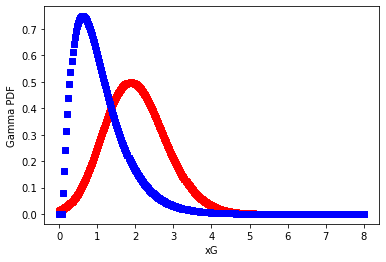

Season               2021
Date           2021-12-12
Home Team      Villarreal
Away Team       Vallecano
Home Goals           2.12
Away Goals           1.36
Home Atk            1.652
Home Def            1.178
Away Atk            1.159
Away Def           2.0115
Theory_home      1.760863
Theory_away      1.003717
Name: 378, dtype: object


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

y = x
buckets = np.linspace(0, 8, num=300)
pdf_buckets_home = [gamma.pdf(buckets[x], constraints_home[0], constraints_home[1], constraints_home[2]) for x in range(len(buckets))]
pdf_buckets_away = [gamma.pdf(buckets[x], constraints_away[0], constraints_away[1], constraints_away[2]) for x in range(len(buckets))]
plt.scatter(buckets, pdf_buckets_home, c='red', marker='s')
plt.scatter(buckets, pdf_buckets_away, c='blue', marker='s')
plt.xlabel('xG')
plt.ylabel('Gamma PDF')
plt.show()
disp_cols = ['Season', 'Date', 'Home Team', 'Away Team', 'Home Goals', 'Away Goals', 'Home Atk', 'Home Def', 'Away Atk', 'Away Def', 'Theory_home', 'Theory_away']
print(test_data[disp_cols].iloc[y])

In [ ]:
import random as rand

r1 = range(len(test_data))
r2 = range(len(a) - 1)
odds = np.empty([len(test_data), 3])
for i in r1:
  home_odds = 0
  away_odds = 0
  draw_odds = 0
  for j in r2:
    for k in r2:
      if (abs(integral_values[i][j][0] - integral_values[i][k][0]) < .325):
        draw_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif rand.random() < .025:
        draw_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif (integral_values[i][j][0] > integral_values[i][k][0]):
        home_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif (integral_values[i][k][0] > integral_values[i][j][0]):
        away_odds += (integral_values[i][j][1] * integral_values[i][k][2])
  odds[i] = [home_odds, away_odds, draw_odds]

In [ ]:
def CalcBet(df, x):
    threshold = .15
    if df['Draw Edge'].iloc[x] > (threshold):
        return 'D'
    max_edge = max(df['Home Edge'].iloc[x], df['Away Edge'].iloc[x])
    if max_edge < threshold:
        return 'No Bet'
    elif max_edge == df['Home Edge'].iloc[x]:
        return 'H'
    else:
        return 'A'
    
def CalcProfit(df, x):
    if df['Model Bet'].iloc[x] == 'No Bet':
        return 0
    elif df['Model Bet'].iloc[x] == df['Result'].iloc[x]:
        if df['Model Bet'].iloc[x] == 'H':
            return (1/df['Home Odds'].iloc[x] - 1)
        elif df['Model Bet'].iloc[x] == 'A':
            return (1/df['Away Odds'].iloc[x] - 1)
        else:
            return (1/df['Draw Odds'].iloc[x] - 1)
    else:
        return -1

# These rely on integrating slices of the PDF function
#test_data['Home Prob'] = [odds[x][0] for x in range(len(odds))]
#test_data['Away Prob'] = [odds[x][1] for x in range(len(odds))]
#test_data['Draw Prob'] = [odds[x][2] for x in range(len(odds))]

draw_prob = len(sample_data[sample_data['Result'] == 'D']) / len(sample_data)

test_data['Home Prob'] = [test_data['Gamma Pred Pythag'][x] - (.5 * draw_prob) for x in range(len(test_data))]
test_data['Away Prob'] = [(1 - test_data['Gamma Pred Pythag'][x]) - (.5 * draw_prob) for x in range(len(test_data))]
test_data['Draw Prob'] = [1 - (test_data['Home Prob'][x] + test_data['Away Prob'][x]) for x in range(len(test_data))]

test_data['Home Edge'] = [test_data['Home Prob'][x] - test_data['Home Odds'][x] for x in range(len(test_data))]
test_data['Away Edge'] = [test_data['Away Prob'][x] - test_data['Away Odds'][x] for x in range(len(test_data))]
test_data['Draw Edge'] = [test_data['Draw Prob'][x] - test_data['Draw Odds'][x] for x in range(len(test_data))]
test_data['Model Bet'] = [CalcBet(test_data, x) for x in range(len(test_data))]
test_data['Profit'] = [CalcProfit(test_data, x) for x in range(len(test_data))]

print('Total Profit: ', test_data['Profit'].sum(), ' on ', len(test_data[test_data['Model Bet'] != 'No Bet']), ' total bets')
print(test_data.loc[test_data['Model Bet'] == 'H', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'H']), ' H bets')
print(test_data.loc[test_data['Model Bet'] == 'A', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'A']), ' A bets')
print(test_data.loc[test_data['Model Bet'] == 'D', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'D']), ' D bets')

print('\nTotal games in the dataset: ', len(test_data))
print('Total games in the sample: ', len(sample_data))
print('\nAverage draw probability: ', test_data['Draw Prob'].mean())
print('Percentage of games drawn: ', len(test_data[test_data['Result'] == 'D']) / len(test_data))
print('Average implied probability of a draw: ', test_data['Draw Odds'].mean())

print('\nAverage home win probability: ', test_data['Home Prob'].mean())
print('Percentage of games won by home team: ', len(test_data[test_data['Result'] == 'H']) / len(test_data))
print('Average implied probability: ', test_data['Home Odds'].mean())

print('\nAverage away win probability: ', test_data['Away Prob'].mean())
print('Percentage of games won by away team: ', len(test_data[test_data['Result'] == 'A']) / len(test_data))
print('Average implied probability: ', test_data['Away Odds'].mean())

print('\nTotal Hold: ', (test_data['Draw Odds'].mean() + test_data['Home Odds'].mean() + test_data['Away Odds'].mean()))
print('\nPythag ratios')
print(test_data['Pythag'].mean())
print((len(test_data[test_data['Result'] == 'H']) + .5 * len(test_data[test_data['Result'] == 'D'])) / len(test_data))
print(1 - test_data['Pythag'].mean())
print((len(test_data[test_data['Result'] == 'A']) + .5 * len(test_data[test_data['Result'] == 'D'])) / len(test_data))


Total Profit:  4.53  on  16  total bets
Profit    3.53
dtype: float64  on  8  H bets
Profit    6.0
dtype: float64  on  3  A bets
Profit   -5.0
dtype: float64  on  5  D bets

Total games in the dataset:  302
Total games in the sample:  1210

Average draw probability:  0.24876033057851246
Percentage of games drawn:  0.23841059602649006
Average implied probability of a draw:  0.2455225472828563

Average home win probability:  0.44880491593817196
Percentage of games won by home team:  0.46357615894039733
Average implied probability:  0.46483759991595885

Average away win probability:  0.3024347534833156
Percentage of games won by away team:  0.2980132450331126
Average implied probability:  0.3433855096853581

Total Hold:  1.0537456568841732

Pythag ratios
0.5734581460565729
0.5827814569536424
0.42654185394342714
0.41721854304635764


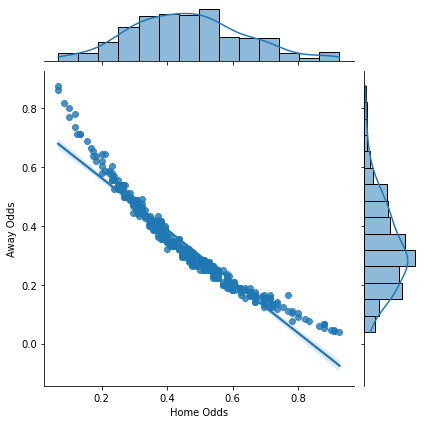

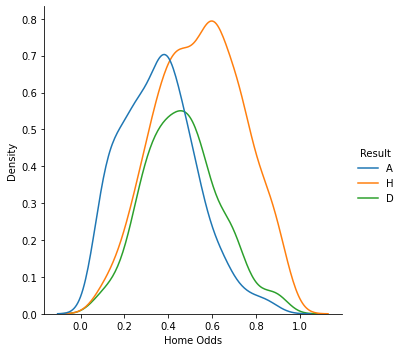

In [ ]:
import seaborn as sns

sns.jointplot(data=game_data[game_data['Result'] == 'D'], x='Home Odds', y='Away Odds', kind='reg')

#sns.jointplot(data=test_data[test_data['Result'] == 'H'], x='Home Prob', y='Home Odds', hue='Model Bet')
#sns.jointplot(data=test_data[test_data['Result'] == 'A'], x='Away Prob', y='Away Odds', hue='Model Bet')
#sns.jointplot(data=test_data[test_data['Result'] == 'D'], x='Draw Prob', y='Draw Odds', hue='Model Bet')

# These display the distribution of projected draws from me and SPI as a check; they should have similar shape
sns.displot(game_data, x='Home Odds', hue='Result', kind='kde')
#sns.displot(test_data['Draw Odds'])
#sns.displot(spi_matches_league['probtie'])

In [14]:
# score1 and score2 represent the actual score of the game
from sklearn.metrics import r2_score
spi_matches = spi_matches[spi_matches['score1'].notna()]
spi_matches['result'] = np.array(spi_matches['score1']) - np.array(spi_matches['score2'])
spi_matches = spi_matches.sort_values(['prob1']).reset_index(drop=True)
proj_score1 = np.array(spi_matches['proj_score1'])
proj_score2 = np.array(spi_matches['proj_score2'])
proj_pythag = np.divide(np.multiply(proj_score1, proj_score1), np.add(np.multiply(proj_score1, proj_score1), np.multiply(proj_score2, proj_score2)))
spi_matches['pythag'] = proj_pythag
leagues = spi_matches['league'].unique()

for league in leagues:  
  league_data = spi_matches[spi_matches['league'] == league].sort_values(['pythag']).reset_index(drop=True)
  bin_size = np.linspace(0, len(league_data), 10, dtype=int)
  bins = [league_data.iloc[bin_size[x]:bin_size[x+1]] for x in range(len(bin_size) - 1)]
  draw_percent = [len(bin[bin['result'] == 0]) / len(bin) for bin in bins]
  avg_pythag = [bin['pythag'].mean() for bin in bins]
  x = avg_pythag
  y = draw_percent
  myline = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(x, y, 2).convert().coef)
  #myspace = np.linspace(0, 1, 100)
  #plt.scatter(x, y)
  #plt.plot(myspace, myline(myspace))
  #plt.show
  pred = [myline(a) for a in x]
  print(league, ' regression: ', myline)
  print(league, ' r^2: ', r2_score(y, pred))
  print('Sample size: ', len(league_data))
  print('Average goals scored per game: ', (league_data['score1'].mean() + league_data['score2'].mean()))
  print(' ')


UEFA Champions League  regression:  0.13345286433376968 + 0.5233497591059924·x¹ - 0.5375869859895128·x²
UEFA Champions League  r^2:  0.3946786576965803
Sample size:  744
Average goals scored per game:  3.063172043010753
 
Scottish Premiership  regression:  0.1806416531968863 + 0.477276600384823·x¹ - 0.5271647609173726·x²
Scottish Premiership  r^2:  0.45578283752710913
Sample size:  1085
Average goals scored per game:  2.5483870967741935
 
French Ligue 1  regression:  0.03698919176530535 + 0.9940505608429557·x¹ - 0.921970646205446·x²
French Ligue 1  r^2:  0.7817797444379936
Sample size:  2179
Average goals scored per game:  2.669573198715007
 
Barclays Premier League  regression:  0.018673244326046223 + 0.9759650567302245·x¹ - 0.896326226117472·x²
Barclays Premier League  r^2:  0.9320535753264988
Sample size:  2280
Average goals scored per game:  2.7557017543859645
 
Dutch Eredivisie  regression:  0.0732352463111467 + 0.8002601210760611·x¹ - 0.7872251952866294·x²
Dutch Eredivisie  r^2: 